<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/master/examples/unsupervised/rbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
tf.random.set_seed(2)

In [207]:
print(tf.__version__)

2.1.0


In [0]:
class RBM:
    
  def __init__(self, input_size, hidden_size, lr=1.0, batchsize=100):

      self._input_size = input_size # Size of visible layer
      self._hidden_size = hidden_size # Size of hidden layer
      self.learning_rate = lr 
      self.batchsize = batchsize      
      
      # Initialise weights to small random values
      self.w = tf.random.normal((input_size, hidden_size), stddev=0.01, dtype=np.float32)
      self.hb = tf.zeros([hidden_size], np.float32)
      self.vb = tf.zeros([input_size], np.float32)

  def prob_h_given_v(self, v):
      return tf.nn.sigmoid(tf.matmul(v, self.w) + self.hb)

  def sample_h_given_v(self, v):
      return self.sample_prob(self.prob_h_given_v(v))

  def prob_v_given_h(self, h):
      return tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.w)) + self.vb)

  def sample_v_given_h(self, h):
      return self.sample_prob(self.prob_v_given_h(h))

  def sample_prob(self, probs):
      return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))
      
  def sample(self, visible, steps=500):
    v = visible
    for step in range(steps):
      h = self.sample_h_given_v(v)
      v = self.sample_v_given_h(h)
    return v

  # Training method for the model
  def train(self, X, epochs=10):
      
    loss = []
    for epoch in range(epochs):
        #For each step/batch
        for start, end in zip(range(0, len(X), self.batchsize),range(self.batchsize,len(X), self.batchsize)):
            batch = X[start:end]
            
            # Perform 1 step of CD
            
            h0 = self.sample_h_given_v(batch)
            v1 = self.sample_v_given_h(h0)
            h1 = self.sample_h_given_v(v1)
            
            # Calculate gradients 
            positive_grad = tf.matmul(tf.transpose(batch), h0)
            negative_grad = tf.matmul(tf.transpose(v1), h1)
            
            #Update parameters
            self.w += self.learning_rate *(positive_grad - negative_grad) / tf.dtypes.cast(tf.shape(batch)[0],tf.float32)
            #self.w += self.learning_rate * tf.reduce_mean(positive_grad - negative_grad)
            self.vb += self.learning_rate * tf.reduce_mean(batch - v1, 0)
            self.hb += self.learning_rate * tf.reduce_mean(h0 - h1, 0)
            
        #Find the error rate
        err = tf.reduce_mean(tf.square(batch - v1))
        print ('Epoch: %d' % epoch,'reconstruction error: %f' % err)
        loss.append(err)          
        
    return loss

Read in MNIST data, convert to binary units andf flatten

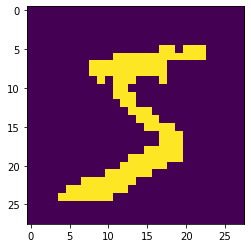

In [209]:
(train_data, _), (test_data, _) =  tf.keras.datasets.mnist.load_data()
train_data = np.round(train_data/ 255)
test_data = np.round(test_data/ 255)
plt.imshow(train_data[0])
plt.show()
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1] * train_data.shape[2])).astype(np.float32)
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1] * test_data.shape[2])).astype(np.float32)

In [0]:
input_size = train_data.shape[1]
rbm = RBM(input_size, 200)

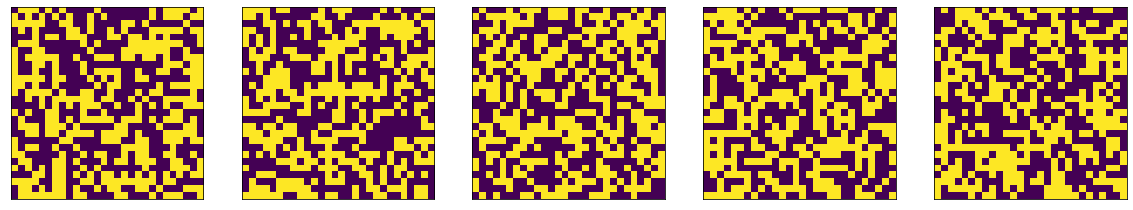

In [211]:
samples = rbm.sample(train_data[0:5])
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20,4))
for i in range(5):
  axes[i].imshow(tf.reshape(samples[i],[28, 28]))
  axes[i].get_xaxis().set_visible(False)
  axes[i].get_yaxis().set_visible(False)

In [212]:
err = rbm.train(train_data, 10)

Epoch: 0 reconstruction error: 0.063163
Epoch: 1 reconstruction error: 0.052908
Epoch: 2 reconstruction error: 0.050625
Epoch: 3 reconstruction error: 0.048202
Epoch: 4 reconstruction error: 0.045217
Epoch: 5 reconstruction error: 0.043622
Epoch: 6 reconstruction error: 0.043559
Epoch: 7 reconstruction error: 0.044196
Epoch: 8 reconstruction error: 0.041671
Epoch: 9 reconstruction error: 0.041059


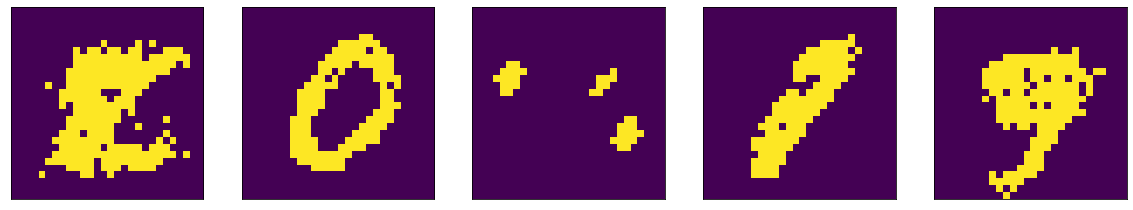

In [213]:
samples = rbm.sample(train_data[0:5])
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20,4))
for i in range(5):
  axes[i].imshow(tf.reshape(samples[i],[28, 28]))
  axes[i].get_xaxis().set_visible(False)
  axes[i].get_yaxis().set_visible(False)

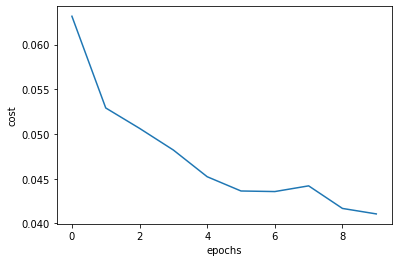

In [215]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()